In [1]:
import pandas as pd 
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import os
from os.path import dirname

In [2]:
parent_dir = os.path.dirname(os.getcwd())
custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%Y")
data=pd.read_csv(parent_dir +  "/data/BTC ML Final.csv", parse_dates=['Date'], date_parser=custom_date_parser)
data.head()

,Date,HL,OC,AdjClose,Volume,ChangePer,UpDownSign,RSI,STCK,STCD,WILLS,MACD,ROCP,OBV,volatility
0,2014-10-18,0.042713,-0.019444,391.441986,11416800.0,1.962996,0,75.469711,0.760150,0.835494,-0.239850,-3.865832,-0.037463,-17386392.0,0.060301
1,2014-10-19,0.019360,0.004365,389.545990,5914570.0,-0.486719,0,79.658723,0.706411,0.793553,-0.293589,-2.739588,-0.097958,-23300962.0,0.060942
2,2014-10-20,0.031281,0.016407,382.845001,16419000.0,-1.750314,1,73.241668,0.192464,0.678191,-0.807536,-2.360535,-0.055866,-39719962.0,0.055016
3,2014-10-21,0.031016,-0.010601,386.475006,14188900.0,0.939260,0,72.644511,0.213990,0.565904,-0.786010,-1.747082,-0.050244,-25531062.0,0.046441
4,2014-10-22,0.016552,0.007666,383.157990,11641300.0,-0.865705,0,65.480216,0.032870,0.441208,-0.967130,-1.511153,-0.095417,-37172362.0,0.045207


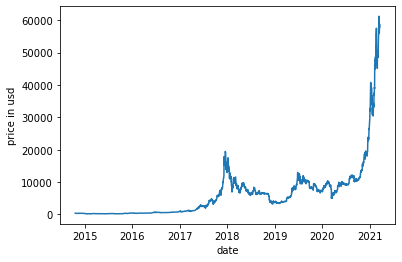

In [23]:
df_close = data[['Date', 'ChangePer', 'AdjClose', 'UpDownSign']]
plt.plot(df_close['Date'], df_close['AdjClose'])
plt.xlabel('date')
plt.ylabel('price in usd')
plt.show()

In [24]:
df_close.head()

,Date,ChangePer,AdjClose,UpDownSign
0,2014-10-18,1.962996,391.441986,0
1,2014-10-19,-0.486719,389.545990,0
2,2014-10-20,-1.750314,382.845001,1
3,2014-10-21,0.939260,386.475006,0
4,2014-10-22,-0.865705,383.157990,0


# Scale data

In [25]:
scaler = MinMaxScaler()
df_close['scale'] = scaler.fit_transform(df_close['AdjClose'].values.reshape(-1,1))

<ipython-input-25-03f81b4651d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close['scale'] = scaler.fit_transform(df_close['AdjClose'].values.reshape(-1,1))


In [26]:
df_close.head()

,Date,ChangePer,AdjClose,UpDownSign,scale
0,2014-10-18,1.962996,391.441986,0,0.003494
1,2014-10-19,-0.486719,389.545990,0,0.003463
2,2014-10-20,-1.750314,382.845001,1,0.003353
3,2014-10-21,0.939260,386.475006,0,0.003412
4,2014-10-22,-0.865705,383.157990,0,0.003358


In [27]:
df_train = df_close[df_close['Date'] <= '2019-12-31']
df_train

,Date,ChangePer,AdjClose,UpDownSign,scale
0,2014-10-18,1.962996,391.441986,0,0.003494
1,2014-10-19,-0.486719,389.545990,0,0.003463
2,2014-10-20,-1.750314,382.845001,1,0.003353
3,2014-10-21,0.939260,386.475006,0,0.003412
4,2014-10-22,-0.865705,383.157990,0,0.003358
...,...,...,...,...,...
1896,2019-12-27,0.701248,7290.088379,1,0.116466
1897,2019-12-28,0.381278,7317.990234,1,0.116923
1898,2019-12-29,1.410043,7422.652832,0,0.118637
1899,2019-12-30,-1.777839,7292.995117,0,0.116513


In [60]:
df_test = df_close[(df_close['Date'] > '2019-12-31') & (df_close['Date'] <= '2020-12-31') ]
df_test.reset_index(drop=True, inplace=True)
df_test

,Date,ChangePer,AdjClose,UpDownSign,scale
0,2020-01-01,0.091320,7200.174316,0,0.114993
1,2020-01-02,-3.073581,6985.470215,1,0.111477
2,2020-01-03,4.893393,7344.884277,1,0.117363
3,2020-01-04,0.887539,7410.656738,1,0.118440
4,2020-01-05,0.008914,7411.317383,1,0.118451
...,...,...,...,...,...
357,2020-12-27,-0.627057,26272.294920,1,0.427318
358,2020-12-28,2.999887,27084.808590,1,0.440624
359,2020-12-29,1.014635,27362.437500,1,0.445171
360,2020-12-30,5.126445,28840.953130,1,0.469383


# Split the dataset into training data and testing data

In [6]:
#create historical data
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [29]:
x_train, y_train = create_dataset(df_train['scale'])
x_test, y_test = create_dataset(df_test['scale'])

# Train the model

In [36]:
clf = MLPRegressor(activation = 'tanh',solver='adam')
clf.fit(x_train,y_train)
train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)
print ('MSE training', mean_squared_error(train_pred,y_train))
print ('MSE testing', mean_squared_error(test_pred,y_test))

MSE training 4.566733639634061e-05
MSE testing 0.00010598860943002291


In [35]:
clf.score(x_test, y_test)

0.9817799438334448

In [41]:
scaler.inverse_transform(y_train.reshape(-1,1))

array([[ 386.475006],
       [ 383.15799 ],
       [ 358.416992],
       ...,
       [7422.652832],
       [7292.995117],
       [7193.599121]])

Text(0, 0.5, 'price in usd')

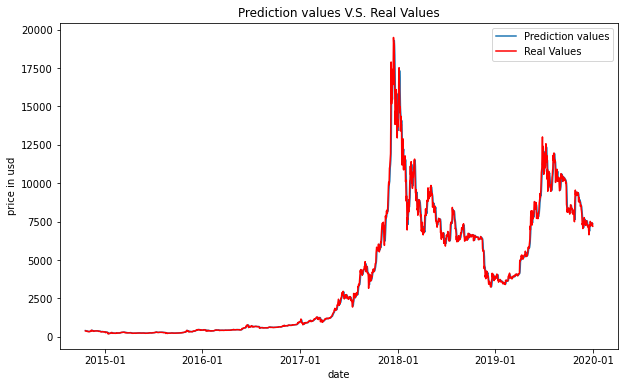

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_train.iloc[3:].Date, scaler.inverse_transform(train_pred.reshape(-1,1)),label='Prediction values')
ax.plot(df_train.iloc[3:].Date, scaler.inverse_transform(y_train.reshape(-1,1)),color='red', label='Real Values')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.set_title('Prediction values V.S. Real Values')
ax.set_xlabel('date')
ax.set_ylabel('price in usd')

Text(0, 0.5, 'price in usd')

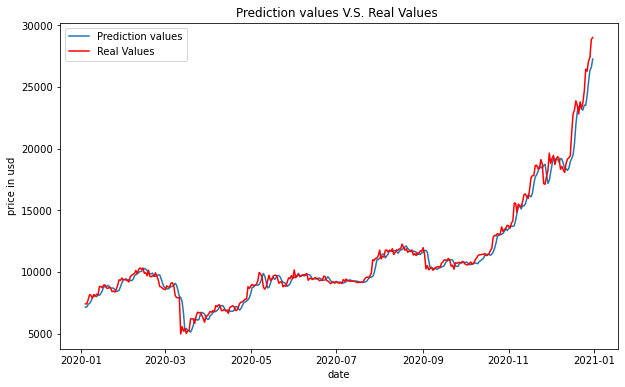

In [47]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df_test.iloc[3:].Date, scaler.inverse_transform(test_pred.reshape(-1,1)),label='Prediction values')
ax.plot(df_test.iloc[3:].Date, scaler.inverse_transform(y_test.reshape(-1,1)),color='red', label='Real Values')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
ax.set_title('Prediction values V.S. Real Values ')
ax.set_xlabel('date')
ax.set_ylabel('price in usd')

# Trading 

In [50]:
prediction = scaler.inverse_transform(test_pred.reshape(-1,1))
T_value = scaler.inverse_transform(y_test.reshape(-1,1))

In [64]:
prediction

array([[ 7144.72448674],
       [ 7162.65068949],
       [ 7378.58984906],
       [ 7454.52426911],
       [ 7624.53452823],
       [ 7945.04807429],
       [ 8104.79335399],
       [ 8022.05796568],
       [ 8000.22993524],
       [ 8126.90949501],
       [ 8106.38079593],
       [ 8249.78310218],
       [ 8460.36660854],
       [ 8810.65735909],
       [ 8793.58833982],
       [ 8822.17443249],
       [ 8910.48302412],
       [ 8829.73906442],
       [ 8695.73472318],
       [ 8693.14881089],
       [ 8686.84954015],
       [ 8560.4641572 ],
       [ 8418.0552011 ],
       [ 8437.66265275],
       [ 8511.33151994],
       [ 8794.17821503],
       [ 9114.20551188],
       [ 9362.14823076],
       [ 9388.93802919],
       [ 9441.63996634],
       [ 9365.89277513],
       [ 9365.95276407],
       [ 9309.465617  ],
       [ 9291.60590811],
       [ 9395.29981849],
       [ 9675.5575255 ],
       [ 9768.92093663],
       [ 9856.91289656],
       [ 9952.5651638 ],
       [10036.45245943],


In [58]:
len(prediction)

359

In [51]:
T_value

array([[ 7410.656738],
       [ 7411.317383],
       [ 7769.219238],
       [ 8163.692383],
       [ 8079.862793],
       [ 7879.071289],
       [ 8166.554199],
       [ 8037.537598],
       [ 8192.494141],
       [ 8144.194336],
       [ 8827.764648],
       [ 8807.010742],
       [ 8723.786133],
       [ 8929.038086],
       [ 8942.808594],
       [ 8706.245117],
       [ 8657.642578],
       [ 8745.894531],
       [ 8680.875977],
       [ 8406.515625],
       [ 8445.43457 ],
       [ 8367.847656],
       [ 8596.830078],
       [ 8909.819336],
       [ 9358.589844],
       [ 9316.629883],
       [ 9508.993164],
       [ 9350.529297],
       [ 9392.875   ],
       [ 9344.365234],
       [ 9293.521484],
       [ 9180.962891],
       [ 9613.423828],
       [ 9729.801758],
       [ 9795.943359],
       [ 9865.119141],
       [10116.67383 ],
       [ 9856.611328],
       [10208.23633 ],
       [10326.05469 ],
       [10214.37988 ],
       [10312.11621 ],
       [ 9889.424805],
       [ 99

In [53]:
df_test.head()

,Date,ChangePer,AdjClose,UpDownSign,scale
0,2020-01-01,0.091320,7200.174316,0,0.114993
1,2020-01-02,-3.073581,6985.470215,1,0.111477
2,2020-01-03,4.893393,7344.884277,1,0.117363
3,2020-01-04,0.887539,7410.656738,1,0.118440
4,2020-01-05,0.008914,7411.317383,1,0.118451


In [61]:
df_test = df_test.iloc[3:]
df_test.head()

,Date,ChangePer,AdjClose,UpDownSign,scale
3,2020-01-04,0.887539,7410.656738,1,0.118440
4,2020-01-05,0.008914,7411.317383,1,0.118451
5,2020-01-06,4.606664,7769.219238,1,0.124312
6,2020-01-07,4.832043,8163.692383,0,0.130772
7,2020-01-08,-1.037513,8079.862793,0,0.129399


In [62]:
df_test['prediction'] = prediction

<ipython-input-62-aff6c12989f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['prediction'] = prediction


In [63]:
df_test.head()

,Date,ChangePer,AdjClose,UpDownSign,scale,prediction
3,2020-01-04,0.887539,7410.656738,1,0.118440,7144.724487
4,2020-01-05,0.008914,7411.317383,1,0.118451,7162.650689
5,2020-01-06,4.606664,7769.219238,1,0.124312,7378.589849
6,2020-01-07,4.832043,8163.692383,0,0.130772,7454.524269
7,2020-01-08,-1.037513,8079.862793,0,0.129399,7624.534528


In [65]:
signals = np.zeros(len(df_test)-1)

In [67]:
df_test.prediction.iloc[1]

7162.650689491821

In [69]:
for i in range(0, len(df_test)-1):
    if df_test.prediction.iloc[i] <= df_test.prediction.iloc[i+1]:
        signals[i] = 1      
    else:
        signals[i] = 0

mark = 0
for i in range(0, len(signals)):
    if signals[i] == df_test.UpDownSign.iloc[i]:
        mark = mark + 1
    else:
        pass
acc = mark/len(signals)
print(acc)

0.4972067039106145


In [79]:
mean_squared_error(signals,df_test.UpDownSign.iloc[:-1] )

0.5027932960893855

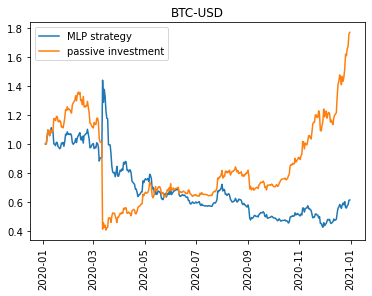

In [74]:
actual_return = df_test['ChangePer']/100
index = df_test.Date
ret=actual_return.to_numpy()
length=len(ret)
signals=signals
value=np.zeros(length)
investment=np.zeros(length)
value[0]=1
investment[0]=1
for i in range(0,length-1):
    if signals[i]==1:
        value[i+1]=value[i]*(1+ret[i+1])
    else: 
        value[i+1]=value[i]*(1-ret[i+1])
    investment[i+1]=investment[i]*(1+ret[i+1])

#plot figure
fig, ax=plt.subplots()
plt.plot(index, value, label='MLP strategy')
plt.plot(index, investment, label='passive investment')
plt.xticks(rotation=90)
plt.title("BTC-USD")
plt.legend()

every_nth = 1
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [75]:
strategy_return=np.zeros(length)
for i in range(0,length-1):
    strategy_return[i]=value[i+1]/value[i]-1
std_strategy=strategy_return.std()*np.sqrt(length)
std_invest=ret.std()*np.sqrt(length)
ret_strategy=(value[-1]/value[0]-1)
ret_invest=(investment[-1]/investment[0]-1)
rf= 0.61/100 #10Y bond yield
SR_strategy=(ret_strategy-rf)/std_strategy
SR_invest=(ret_invest-rf)/std_invest
print("Return: strategy ",ret_strategy, " investment ", ret_invest)
print("Standard deviation: strategy ",std_strategy, " investment ", std_invest)
print("Sharpe ratio: strategy ",SR_strategy, " investment ", SR_invest)

Return: strategy  -0.38523895605016845  investment  0.7693065271693327
Standard deviation: strategy  0.8437343135571636  investment  0.8419674578197491
Sharpe ratio: strategy  -0.4638177560899388  investment  0.9064560869675823
